In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.6/978.6 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 86.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but 

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack
from underthesea import pos_tag
from wordcloud import WordCloud
import re
import string

In [3]:
data = pd.read_csv('/kaggle/input/vietnamese-text-classification-dataset/train.csv')
df = pd.DataFrame(data)
df.columns = ['Label', 'Review']
df

,Label,Review
0,0,chỉ có dây cáp nguồn không có adapter sao sử d...
1,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
2,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
3,2,Tuyệt vời. Hàng FPT cửa hàng
4,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...
...,...,...
3034,0,không có bộ thu đi kèm Vừa nhận hàng xong tức ...
3035,0,Cũng bình thường Không mạnh như kỹ vọng Chắc t...
3036,2,tốt tốt đang tiền khi bỏ ra để mua giao hàng n...
3037,0,giao hàng lâu rửa tay một tí đã cháy màn hình ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   3039 non-null   int64 
 1   Review  3039 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.6+ KB


# **1. EDA**

**Statistical Analysis**

In [5]:
sentence = df["Review"]
#Number of sentences 
sent_num = len(sentence)
print(f'The number of sentences: {sent_num}')
#Sum of characters 
sum_chars = sentence.str.len().sum()
print(f'Sum of characters: {sum_chars}')
#Average length of each sentence 
sent_avg = sentence.str.len().mean()
print(f'Average length of each sentence: {sent_avg}')
#Sum of all words 
all_words = " ".join(sentence).split()
sum_words = len(all_words)
print(f'Sum of all words: {sum_words}')
#Sum of unique words
unique_words = len(set(all_words))
print(f'Sum of unique words: {unique_words}')

The number of sentences: 3039
Sum of characters: 399320
Average length of each sentence: 131.39848634419218
Sum of all words: 90666
Sum of unique words: 6026


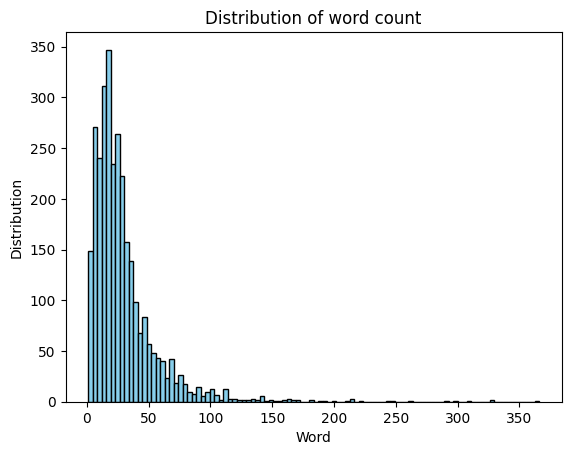

In [6]:
#Plot statistics for word count 
def plot (df):
    word_count = sentence.str.split().str.len()
    plt.hist(word_count, bins=100, color="skyblue", edgecolor="black")
    plt.title("Distribution of word count")
    plt.xlabel("Word")
    plt.ylabel("Distribution")

    plt.show()
plot(sentence) 

This histogram shows that most reviews are short, typically between 10-40 words, with a peak around 20 words. Very long reviews (over 100 words) are rare, and a few outliers exceed 300 words. This suggests the dataset is dominated by concise reviews

<Axes: xlabel='Label', ylabel='count'>

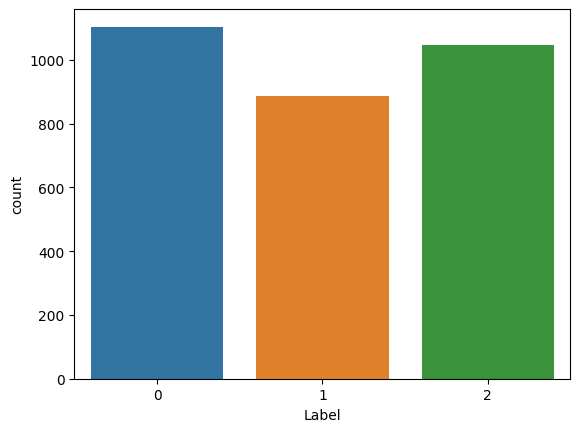

In [7]:
#Count of labels 
sns.countplot(df, x="Label")

# **2. Text Preprocessing**

In [8]:
with open ("/kaggle/input/stop-words-in-28-languages/vietnamese.txt", "r", encoding="utf-8") as f:
    stopwords = [stopwords.strip() for stopwords in f]

print(stopwords[:5])

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy']


In [9]:
df.duplicated().sum()
#Drop duplicates 
df = df.drop_duplicates()

In [10]:
def preprocess_text(text):
    #Lowercase 
    text = text.lower()
    #Remove space 
    text = re.sub(r'\s+', ' ', text).strip()
    #Tokenize 
    tokens = word_tokenize(text, format='list')
    #Remove punctuation
    tokens = [t for t in tokens if t not in string.punctuation]
    #Remove stopwords 
    stop_word = set(stopwords)
    tokens = [t for t in tokens if t not in stop_word]
    return tokens

df['Preprocessed_Review'] = df['Review'].apply(preprocess_text)

/tmp/ipykernel_36/3579402823.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Preprocessed_Review'] = df['Review'].apply(preprocess_text)


In [11]:
df

,Label,Review,Preprocessed_Review
0,0,chỉ có dây cáp nguồn không có adapter sao sử d...,"[dây cáp, adapter, dây cáp, adapter, hàng, tik..."
1,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...,"[chất lượng, kém, 2, loa, bass, âm thanh, rè r..."
2,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...,"[usb, usb, bực bội, nắp, usb, cứng, hộp, đựng,..."
3,2,Tuyệt vời. Hàng FPT cửa hàng,"[tuyệt vời, hàng, fpt, cửa hàng]"
4,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...,"[đo, chân, gián đoạn, hài lòng, hàng không, ti..."
...,...,...,...
3032,1,Nhanh hết pin Không biết phải lỗi hay không Mà...,"[pin, lỗi, hộp, xài, dung, lương, nhanh chóng ..."
3034,0,không có bộ thu đi kèm Vừa nhận hàng xong tức ...,"[thu, đi, kèm, hàng, xong, hàng không, kèm, th..."
3035,0,Cũng bình thường Không mạnh như kỹ vọng Chắc t...,"[bình thường, kỹ vọng, tường, dày, tiki, giao,..."
3036,2,tốt tốt đang tiền khi bỏ ra để mua giao hàng n...,"[tiền, mua, giao, hàng, đóng gói, cẩn thận]"


# **3. Feature Engineering**

In [12]:
df["Preprocessed_Review"] = df["Preprocessed_Review"].apply(lambda tokens: " ".join(tokens))
#Apply TF-IDF with unigrams and bigrams 
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['Preprocessed_Review'])
print(X_tfidf.shape)

(2999, 24070)


/tmp/ipykernel_36/716761299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Preprocessed_Review"] = df["Preprocessed_Review"].apply(lambda tokens: " ".join(tokens))


In [13]:
#Count of POS
def pos_counts(text):
    tags = pos_tag(" ".join(text))
    noun_count = sum(1 for w, t in tags if t == "N")
    verb_count = sum(1 for w, t in tags if t == "V")
    adj_count  = sum(1 for w, t in tags if t == "A")
    return [noun_count, verb_count, adj_count]

X_pos = np.array(df["Preprocessed_Review"].apply(pos_counts).to_list())
print(X_pos.shape)

(2999, 3)


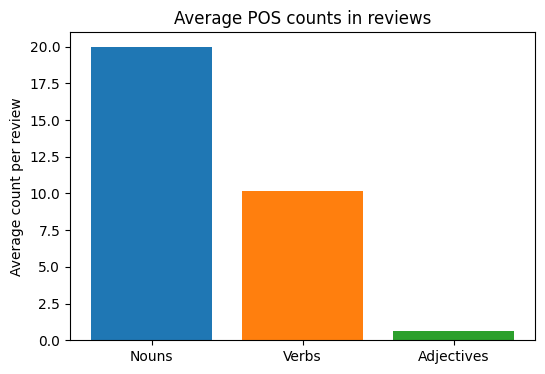

In [14]:
avg_counts = X_pos.mean(axis=0)

plt.figure(figsize=(6,4))
plt.bar(["Nouns","Verbs","Adjectives"], avg_counts, color=["#1f77b4","#ff7f0e","#2ca02c"])
plt.ylabel("Average count per review")
plt.title("Average POS counts in reviews")
plt.show()

In [15]:
feature_names = tfidf.get_feature_names_out()
avg_tfidf = X_tfidf.mean(axis=0).A1  
tfidf_df = pd.DataFrame({"term": feature_names,"avg_tfidf": avg_tfidf}).sort_values("avg_tfidf", ascending=False)
print(tfidf_df.head(20))

             term  avg_tfidf
6471         hàng   0.042274
16585         sản   0.025318
14393        phẩm   0.025178
16588    sản phẩm   0.025077
11079         mua   0.020631
5251         giao   0.020082
14736         pin   0.019391
9631         lòng   0.018510
6458          hài   0.018324
6462     hài lòng   0.018221
11470         máy   0.015927
5370          giá   0.015827
5283    giao hàng   0.015672
9950        lượng   0.015575
4117          cửa   0.014718
4118     cửa hàng   0.014698
2858         chất   0.014634
2862   chất lượng   0.014268
23885          ổn   0.013636
16778         tai   0.013239


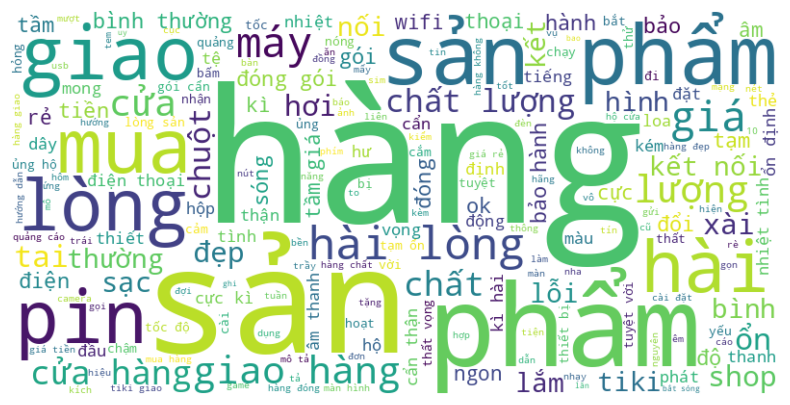

In [16]:
# Create word cloud from tf-idf scores
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
    dict(zip(feature_names, avg_tfidf))
)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
#Input features 
X_features = hstack([X_tfidf, X_pos])
print(X_features.shape)

(2999, 24073)


# **4. Machine Learning**

**a. Support Vector Machine**

In [18]:
#Train-Test split 
X_train, X_test, y_train, y_test = train_test_split(X_features, df["Label"], test_size=0.2, random_state=42, stratify=df["Label"])

In [19]:
svm_clf = LinearSVC(max_iter=5000, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))

SVM Results:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       218
           1       0.71      0.56      0.63       174
           2       0.80      0.77      0.79       208

    accuracy                           0.74       600
   macro avg       0.74      0.73      0.73       600
weighted avg       0.74      0.74      0.74       600



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**b. Naive Bayes**

In [20]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       218
           1       0.86      0.18      0.30       174
           2       0.50      0.98      0.66       208

    accuracy                           0.61       600
   macro avg       0.73      0.58      0.55       600
weighted avg       0.72      0.61      0.57       600



# **5. Evaluation**

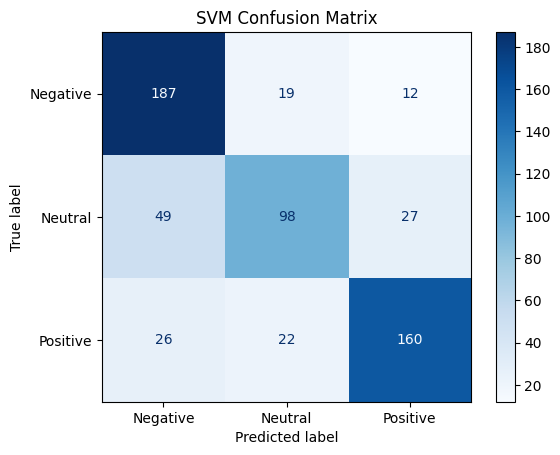

In [21]:
#Confusion matrix for SVM 
cm = confusion_matrix(y_test, y_pred_svm, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Neutral","Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("SVM Confusion Matrix")
plt.show()

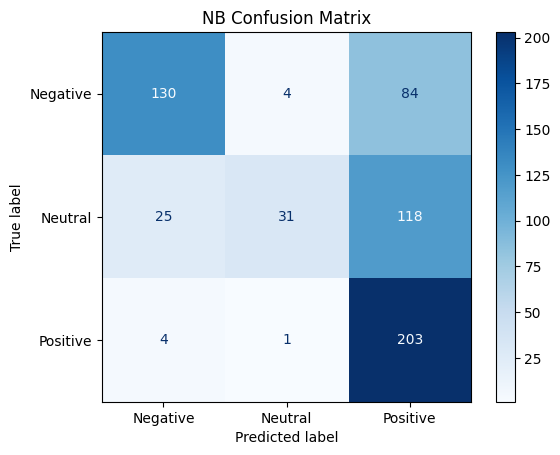

In [22]:
#Confusion matrix for NB
cm = confusion_matrix(y_test, y_pred_nb, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Neutral","Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("NB Confusion Matrix")
plt.show()

**c. Conclusion**

* SVM performs more balanced classification: Negative reviews are recognized very well, Positive reviews are strong with some confusion, but Neutral is the hardest to detect (often mixed with Negative/Positive).
* NB is highly biased toward Positive: it predicts Positive very accurately, but struggles badly with Neutral (often misclassified as Positive) and has moderate performance for Negative.
* Overall, SVM is better if you need consistent accuracy across all classes, while NB is only useful if Positive sentiment detection is the top priority